# Table of contents
>[Machine Learning Applied to Forecasting: Daily Electricity Production in Spain 2014-2018](#scrollTo=r4_L8UtPFLYF)

>>>[Import data](#scrollTo=dQYLOQGGFLYP)

>>[EDA: Exploratory Data Analysis](#scrollTo=JSbd8utCFLYU)

>>[Target Analyisis: Normality](#scrollTo=drfA7M6BFLYU)

>>>[Volatility Analysis](#scrollTo=TTZ5ZwQ9FLYY)

>>>[Time Series Analysis: Seasonality and Trend](#scrollTo=UMOjiAGzFLYZ)

>>[Feature Engineering](#scrollTo=riweetJXFLYb)

>>[Model Building](#scrollTo=FIM4YG_MFLYm)

>>>[Split Data](#scrollTo=IbiqRhL8FLYn)

>>>[Baseline Model: Linear Regression](#scrollTo=pNq8X1M_FLYo)

>>>[Train a Random Forest with Time Series Split to tune Hyperparameters](#scrollTo=wNEyRwYVFLYo)

>>>[Feature Importance](#scrollTo=BEbb01rEFLYp)

>>[Model Assessment:](#scrollTo=34Hi096iFLYq)

>>>[Performance Metrics: MAPE (Mean Absolute Percent Error)](#scrollTo=yDmGJ1lNFLYq)

>>>[Residual Analysis](#scrollTo=m-Ah1y0oFLYr)

>>[Forecasting](#scrollTo=TNiNJ4LsFLYs)

>>>[Muti-period ahead model building](#scrollTo=dW2mrop8FLYs)

>>>[Performance Metrics: MAPE (Mean Absolute Percent Error)](#scrollTo=rf14xht3FLYt)

>>>[Actual vs Forecasted](#scrollTo=qu3hBQV3FLYu)

>>>[Forecasting 30-days ahead](#scrollTo=nIZuxvLdFLYv)



# Machine Learning Applied to Forecasting: Daily Electricity Production in Spain 2014-2018

The main goal of this lab is to test whether a general and simple approach based on Machine Learning models, can yield good enough results in a complex forecasting problem.

Our objective is to test this methodology to perform 30-ahead daily forecast in electricity demand (Spanish market). It is a very complex time series given that the country is not in a stationary economic cycle (recovering from a economic recession) and industrial production is shifting towards tourism and a flourishing but yet quite small, industrial equipment and machine exportation sector. Despite this positive circumstances, both GDP increase and tourism gronwth rate have stopped going up.

This comes with changes in electricity consumption patterns that are also affected by energy efficiency improvements and changes in household consumption behavior.

In addition, some very deep regulation changes where carried out in the last few years (from 2013), that further impact in electricity market, but this impact is more notorious in price time series. Nonetheless, some changes in regulation have triggered a steady switch from regulated tariff to free-market tariff, where a smarter daily consumption profile is encouraged.

The methodology explained is aimed to be an experiment to demonstrate that even with a very simple, easy to implement approach, (but advanced in Machine Learning expertise) we can success in an advanced forecasting problem (long term daily forecasting, only two years of training data and a complex time series). The main profit to be achieved is to no longer rely on methods that require deep time series analysis and heavy statistical assumptions on data, such as ARIMA.

EDA Objectives:
* Is target variable normal with constant volatility
* Is there a seasonal pattern
* Is there a trend pattern

Model building objectives:
* Train a Machine Learning model being able to forecast (predict on future data) 30 periods ahead
* Feature Engineering process is automatic and no assumptions on data statistical properties is required
* Assessment will be carried out computing MAPE (Mean Absolute Percent Error) for each forecating horizong on a holdout dataset

$$ MAPE =\frac{1}{N} \sum_{i=1}^{N}\frac{|y-\hat{y}|}{y}$$


Import the necessary libraries

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from  scipy.stats import skew, kurtosis, shapiro

### Import data

The code reads a CSV file called "data.csv" into a pandas DataFrame, then filters the data to keep rows where the "name" column is "Demanda programada PBF total". It further processes the data by parsing the "datetime" column as dates, setting "date" as the index, and downsampling the data to daily frequency. The final DataFrame includes only the "energy" column, and its information is displayed using the info() method.






In [2]:
path = "data.csv"
data = pd.read_csv(path, sep=",", parse_dates=["datetime"])
data = data[data["name"]=="Demanda programada PBF total"]#.set_index("datetime")
data["date"] = data["datetime"].dt.date
data.set_index("date", inplace=True)
data = data[["value"]]
data = data.asfreq("D")
data = data.rename(columns={"value": "energy"})
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2014-01-01 to 2018-12-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   energy  1825 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


In [3]:
data[:5]

,energy
date,
2014-01-01,620107.7
2014-01-02,659865.2
2014-01-03,632536.8
2014-01-04,610251.7
2014-01-05,572534.1


The code plots the "energy" column from the DataFrame with a title "Energy Demand," sets the y-axis label to "MWh," and displays the plot using Matplotlib.






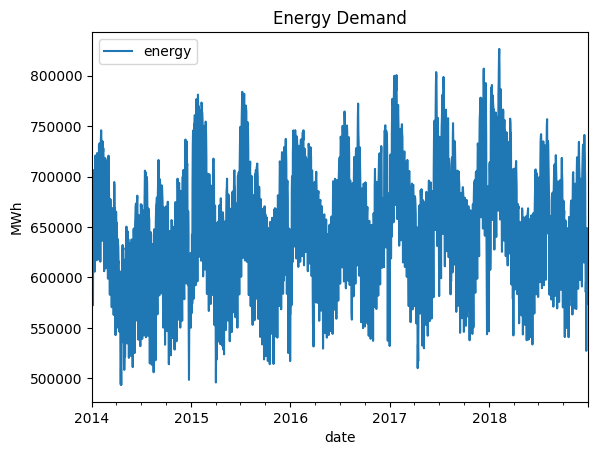

In [4]:
data.plot(title="Energy Demand")
plt.ylabel("MWh")
plt.show()

The code calculates the number of dates in the date range from "2014-01-01" to "2018-12-31," inclusive, using the pd.date_range function.






In [5]:
len(pd.date_range(start="2014-01-01", end="2018-12-31"))

1826

The code adds various date-related columns to the data, calculates rolling averages and standard deviations for different window sizes, and then plots the daily energy demand in Spain along with the 7-day moving average.






<ipython-input-6-4a584e1cb474>:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["week"] = data.index.week


<Figure size 2000x1600 with 0 Axes>

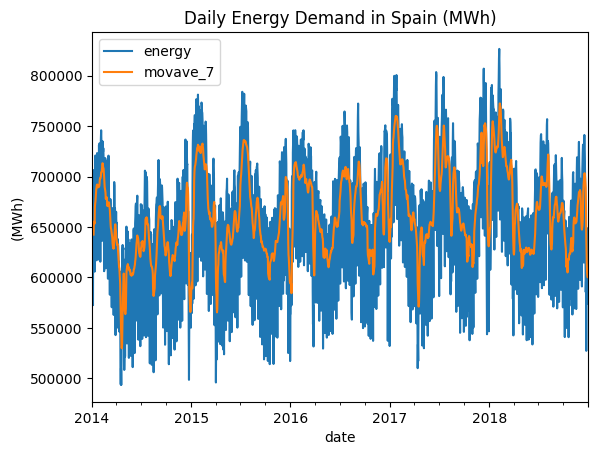

In [6]:
data["year"] = data.index.year
data["qtr"] = data.index.quarter
data["mon"] = data.index.month
data["week"] = data.index.week
data["day"] = data.index.weekday
data["ix"] = range(0,len(data))
data[["movave_7", "movstd_7"]] = data.energy.rolling(7).agg([np.mean, np.std])
data[["movave_30", "movstd_30"]] = data.energy.rolling(30).agg([np.mean, np.std])
data[["movave_90", "movstd_90"]] = data.energy.rolling(90).agg([np.mean, np.std])
data[["movave_365", "movstd_365"]] = data.energy.rolling(365).agg([np.mean, np.std])

plt.figure(figsize=(20,16))
data[["energy", "movave_7"]].plot(title="Daily Energy Demand in Spain (MWh)")
plt.ylabel("(MWh)")
plt.show()

## EDA: Exploratory Data Analysis
* Target Analysis
* Seasonality and Trend

The goal is to graphically characterize time series data, withouth relying on any (almost) any statistical method like decomposing.

## Target Analyisis: Normality

The code calculates the mean, standard deviation, skewness, and excess kurtosis (kurtosis minus 3) of the energy demand data and prints the results.






In [7]:
mean = np.mean(data.energy.values)
std = np.std(data.energy.values)
skew = skew(data.energy.values)
ex_kurt = kurtosis(data.energy)
print("Skewness: {} \nKurtosis: {}".format(skew, ex_kurt+3))

Skewness: -0.2555279252628293 
Kurtosis: 2.6052606972453667


The code defines a function called shapiro_test to perform the Shapiro-Wilk test for normality on the energy demand data. It prints whether the null hypothesis (data is drawn from a normal distribution) is rejected or not based on the significance level (alpha).






In [8]:
def shapiro_test(data, alpha=0.05):
    stat, pval = shapiro(data)
    print("H0: Data was drawn from a Normal Ditribution")
    if (pval<alpha):
        print("pval {} is lower than significance level: {}, therefore null hypothesis is rejected".format(pval, alpha))
    else:
        print("pval {} is higher than significance level: {}, therefore null hypothesis cannot be rejected".format(pval, alpha))

shapiro_test(data.energy, alpha=0.05)

H0: Data was drawn from a Normal Ditribution
pval 2.5459379049408426e-10 is lower than significance level: 0.05, therefore null hypothesis is rejected


The code uses seaborn to plot a distribution of the energy demand data. It also adds vertical lines at the mean and two standard deviations from the mean, providing visual insights into the data's central tendency and spread.






<ipython-input-9-0029366f49ed>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.energy)


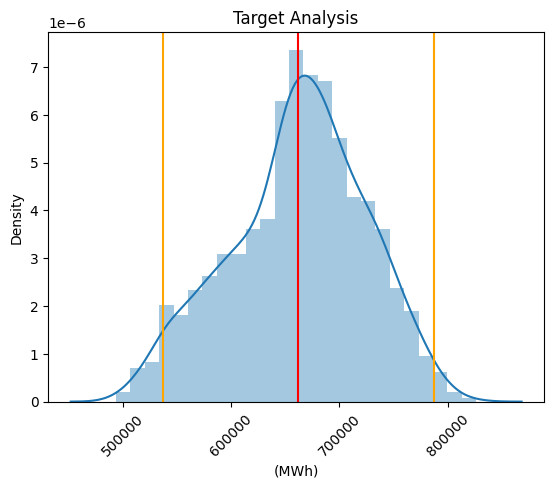

In [9]:
sns.distplot(data.energy)
plt.title("Target Analysis")
plt.xticks(rotation=45)
plt.xlabel("(MWh)")
plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')
plt.show()

### Volatility Analysis

The code calculates rolling quantiles (10th, 50th, and 90th percentiles) of the energy demand data using a window size of 90 days and then plots the results to analyze the volatility.






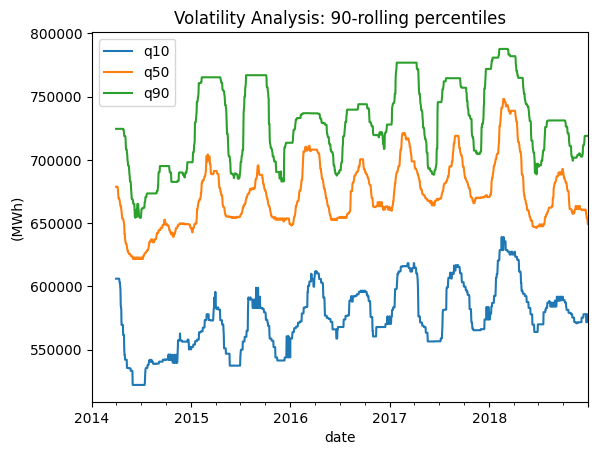

In [10]:
# Insert the rolling quantiles to the monthly returns
data_rolling = data.energy.rolling(window=90)
data['q10'] = data_rolling.quantile(0.1).to_frame("q10")
data['q50'] = data_rolling.quantile(0.5).to_frame("q50")
data['q90'] = data_rolling.quantile(0.9).to_frame("q90")

data[["q10", "q50", "q90"]].plot(title="Volatility Analysis: 90-rolling percentiles")
plt.ylabel("(MWh)")
plt.show()

The code groups the data by quarters, calculates the coefficient of variation (CV) for energy demand within each quarter, and then plots the CV values as a bar chart to compare the variation across different quarters.






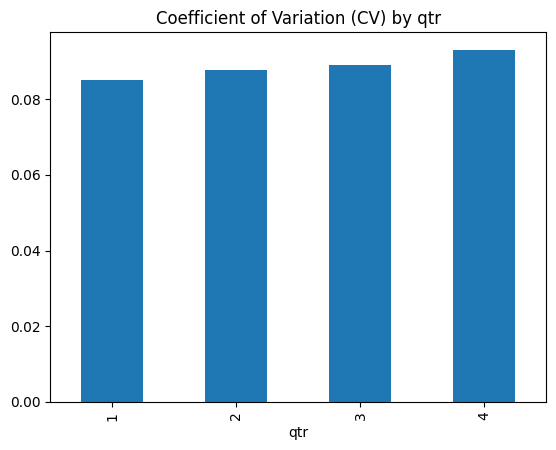

In [11]:
data.groupby("qtr")["energy"].std().divide(data.groupby("qtr")["energy"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by qtr")
plt.show()

The code groups the data by months, calculates the coefficient of variation (CV) for energy demand within each month, and then plots the CV values as a bar chart to compare the variation across different months.






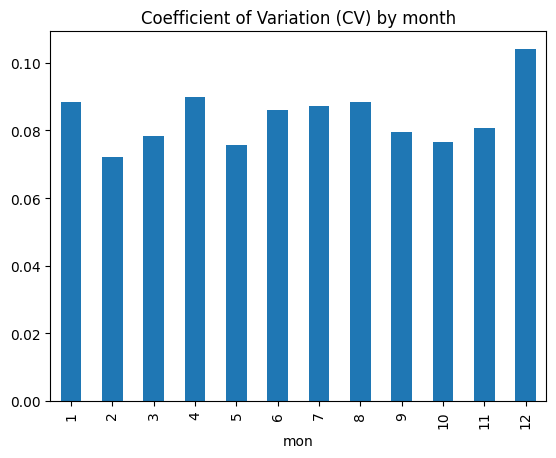

In [12]:
data.groupby("mon")["energy"].std().divide(data.groupby("mon")["energy"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by month")
plt.show()

The code plots the moving standard deviations for energy demand with window sizes of 30 and 365 days, respectively, to analyze heteroscedasticity (changes in variability) over time.






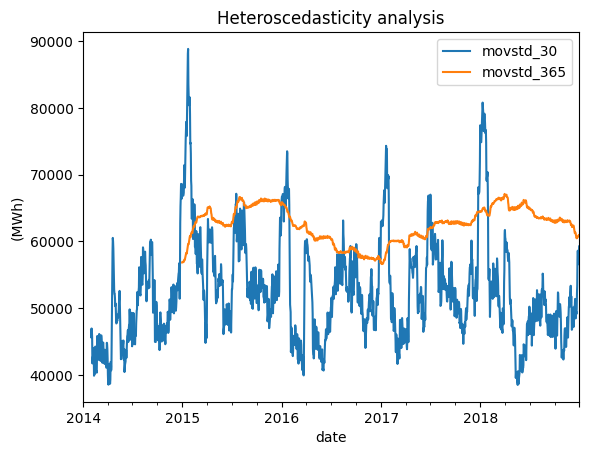

In [13]:
data[["movstd_30", "movstd_365"]].plot(title="Heteroscedasticity analysis")
plt.ylabel("(MWh)")
plt.show()

### Time Series Analysis: Seasonality and Trend

The code plots the moving averages of energy demand with window sizes of 30 and 90 days to visualize seasonal patterns in the data.






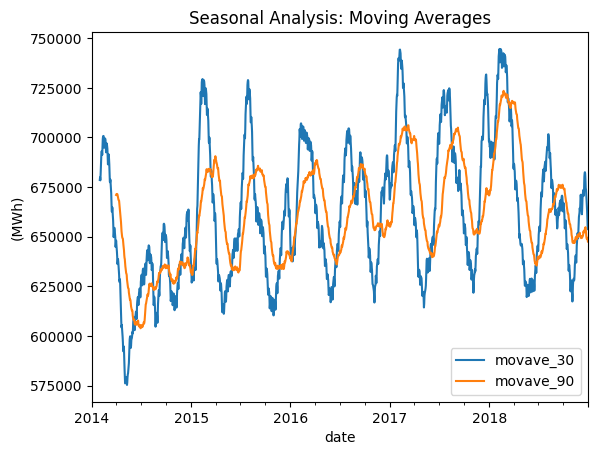

In [14]:
data[["movave_30", "movave_90"]].plot(title="Seasonal Analysis: Moving Averages")
plt.ylabel("(MWh)")
plt.show()

The code creates a boxplot showing the distribution of energy demand over quarters to analyze seasonality patterns in the data.






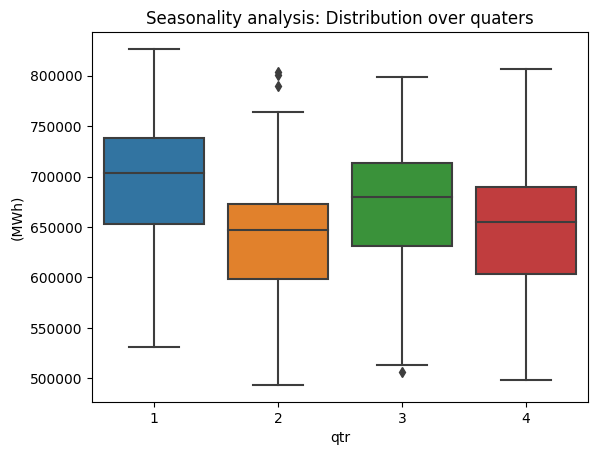

In [15]:
sns.boxplot(data=data, x="qtr", y="energy")
plt.title("Seasonality analysis: Distribution over quaters")
plt.ylabel("(MWh)")
plt.show()

The code creates a boxplot showing the distribution of energy demand over weekdays (days of the week) to analyze seasonality patterns related to weekdays in the data.






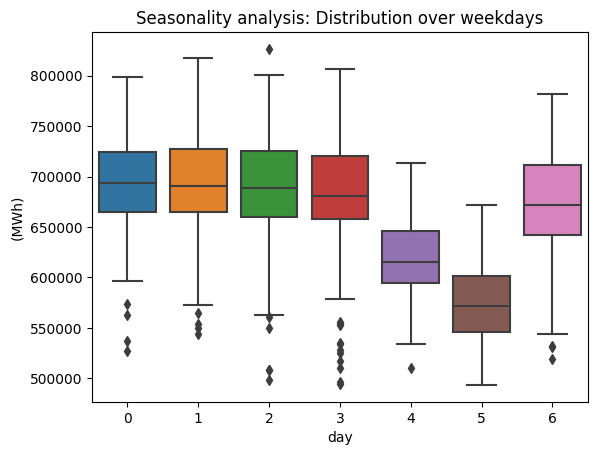

In [16]:
sns.boxplot(data=data, x="day", y="energy")
plt.title("Seasonality analysis: Distribution over weekdays")
plt.ylabel("(MWh)")
plt.show()

The code aggregates the daily energy demand data into monthly sums, adds a new index column, and displays the first five rows of the resulting monthly data frame.






In [17]:
data_mon = data.energy.resample("M").agg(sum).to_frame("energy")
data_mon["ix"] = range(0, len(data_mon))
data_mon[:5]

,energy,ix
date,,
2014-01-31,21017412.7,0
2014-02-28,19336398.7,1
2014-03-31,20040978.6,2
2014-04-30,17633177.7,3
2014-05-31,18572681.6,4


The code creates a regression plot to analyze the trend in monthly energy demand over time, using the index column "ix" as the x-axis and the energy values as the y-axis.






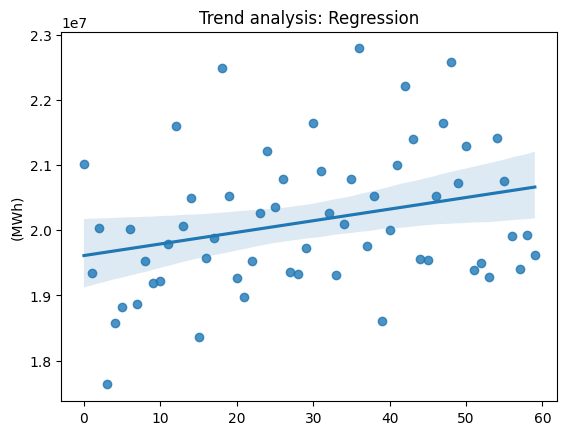

In [18]:
sns.regplot(data=data_mon,x="ix", y="energy")
plt.title("Trend analysis: Regression")
plt.ylabel("(MWh)")
plt.xlabel("")
plt.show()

The code creates a box plot to visualize the distribution of energy demand for each year from 2014 to 2017, providing insight into the annual trends in energy consumption.






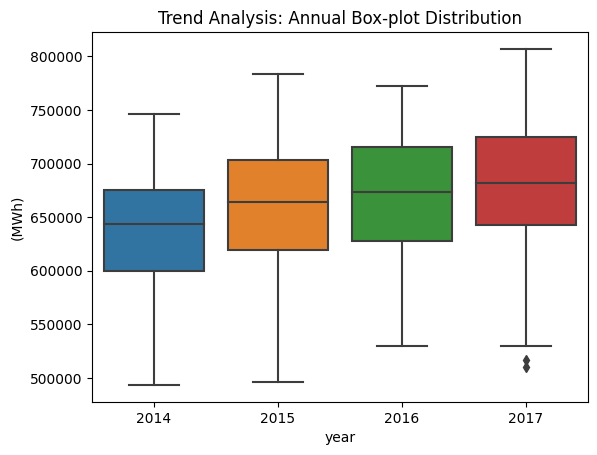

In [19]:
sns.boxplot(data=data["2014":"2017"], x="year", y="energy")
plt.title("Trend Analysis: Annual Box-plot Distribution")
plt.ylabel("(MWh)")
plt.show()

## Feature Engineering


The code creates a new column called "target," which standardizes the energy values by subtracting the mean and dividing by the standard deviation. It then plots the distribution of the standardized energy values.



<ipython-input-20-09e19dba4143>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["target"])


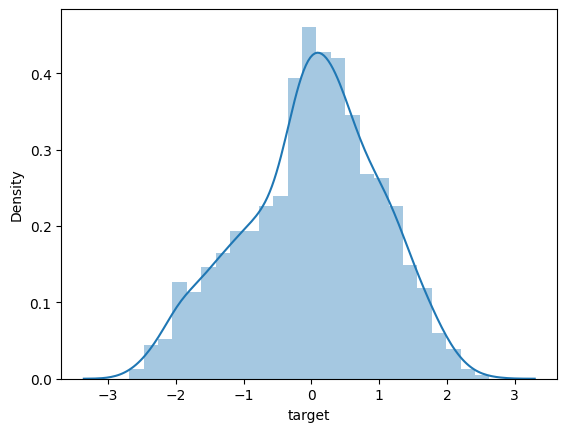

In [20]:
data["target"] = data.energy.add(-mean).div(std)
sns.distplot(data["target"])
plt.show()

The code prepares the dataset for time-series forecasting by creating lag features (using shifting and rolling window calculations) for the target variable, "target," and adds them to the features list. It also creates dummy variables for months and weekdays, adding them to the features list for model training.



In [21]:
features = []
corr_features=[]
targets = []
tau = 30 #forecasting periods

for t in range(1, tau+1):
    data["target_t" + str(t)] = data.target.shift(-t)
    targets.append("target_t" + str(t))

for t in range(1,31):
    data["feat_ar" + str(t)] = data.target.shift(t)
    #data["feat_ar" + str(t) + "_lag1y"] = data.target.shift(350)
    features.append("feat_ar" + str(t))
    #corr_features.append("feat_ar" + str(t))
    #features.append("feat_ar" + str(t) + "_lag1y")


for t in [7, 14, 30]:
    data[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = data.energy.rolling(t).agg([np.mean, np.std, np.max, np.min])
    features.append("feat_movave" + str(t))
    #corr_features.append("feat_movave" + str(t))
    features.append("feat_movstd" + str(t))
    features.append("feat_movmin" + str(t))
    features.append("feat_movmax" + str(t))

months = pd.get_dummies(data.mon,
                              prefix="mon",
                              drop_first=True)
months.index = data.index
data = pd.concat([data, months], axis=1)

days = pd.get_dummies(data.day,
                              prefix="day",
                              drop_first=True)
days.index = data.index
data = pd.concat([data, days], axis=1)


features = features + months.columns.values.tolist() + days.columns.values.tolist()

In [22]:
corr_features = ["feat_ar1", "feat_ar2", "feat_ar3", "feat_ar4", "feat_ar5", "feat_ar6", "feat_ar7", "feat_movave7", "feat_movave14", "feat_movave30"]

The code calculates the correlation matrix between the target variable "target_t1" and the selected features ("corr_features") using Pearson correlation coefficients. It then selects the top 5 features with the highest absolute correlation and plots a heatmap to visualize the correlations.






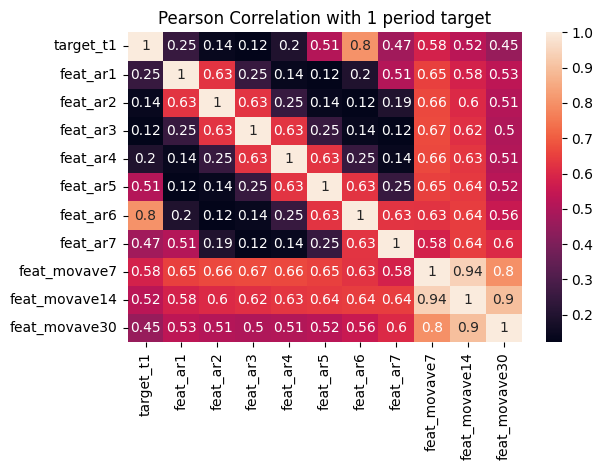

In [23]:
# Calculate correlation matrix
corr = data[["target_t1"] + corr_features].corr()

top5_mostCorrFeats = corr["target_t1"].apply(abs).sort_values(ascending=False).index.values[:6]


# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.title("Pearson Correlation with 1 period target")
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

The code creates a pairplot to visualize the relationships between the top 5 most correlated features with the target variable "target_t1" using regression lines. The plot helps understand how these features are related to each other and their impact on the target variable.






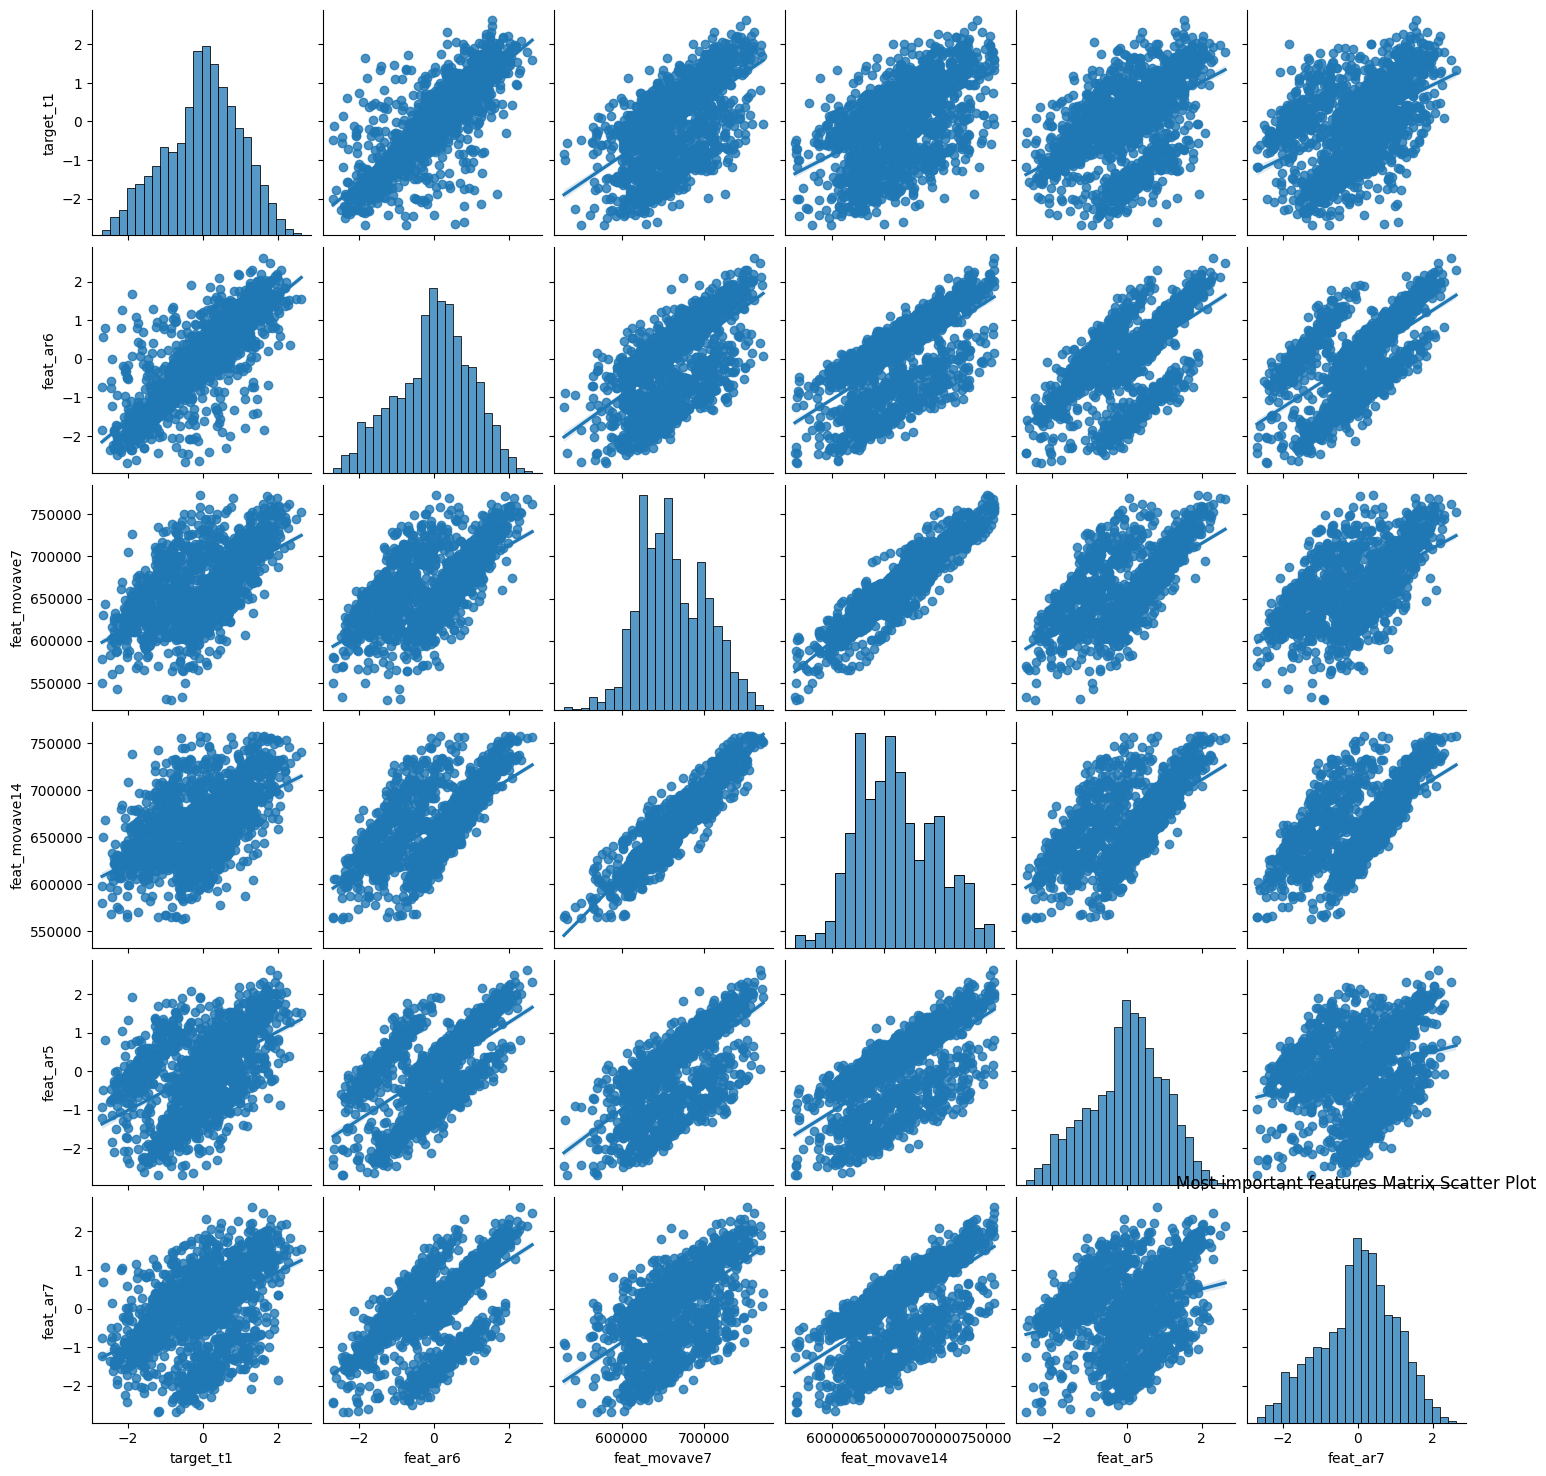

In [24]:
sns.pairplot(data=data[top5_mostCorrFeats].dropna(), kind="reg")
plt.title("Most important features Matrix Scatter Plot")
plt.show()

## Model Building

The code selects the relevant features and target variables from the data, drops any rows with missing values, and then calculates and prints the number of observations in the dataset.






In [25]:
data_feateng = data[features + targets].dropna()
nobs= len(data_feateng)
print("Number of observations: ", nobs)

Number of observations:  1765


### Split Data
The code splits the feature and target variables into training and testing sets based on the time period. It then prints the total number of observations and the shapes of the training and testing datasets. Finally, it creates a plot showing the train-test split over time.






Total number of observations:  1765
Train: (1431, 59)(1431, 30), 
Test: (334, 59)(334, 30)


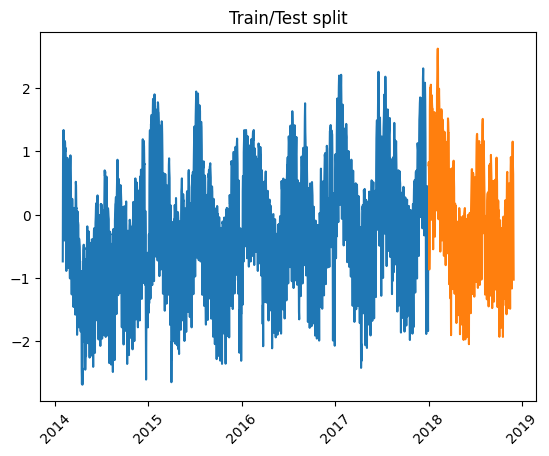

In [26]:

X_train = data_feateng.loc["2014":"2017"][features]
y_train = data_feateng.loc["2014":"2017"][targets]

X_test = data_feateng.loc["2018"][features]
y_test = data_feateng.loc["2018"][targets]

n, k = X_train.shape
print("Total number of observations: ", nobs)
print("Train: {}{}, \nTest: {}{}".format(X_train.shape, y_train.shape,
                                              X_test.shape, y_test.shape))

plt.plot(y_train.index, y_train.target_t1.values, label="train")
plt.plot(y_test.index, y_test.target_t1.values, label="test")
plt.title("Train/Test split")
plt.xticks(rotation=45)
plt.show()

### Baseline Model: Linear Regression

The code fits a linear regression model to the training data and makes predictions on both the training and testing sets. It then calculates the root mean squared error (RMSE) for both the training and testing predictions and prints the results.






In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(X_train, y_train["target_t1"])
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train["target_t1"], p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test["target_t1"], p_test))

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )

Train RMSE: 0.3329800070949785
Test RMSE: 0.27705159884162006


### Train a Random Forest with Time Series Split to tune Hyperparameters

The code performs time series cross-validation using TimeSeriesSplit with 3 splits and a maximum training size of 2 years (365*2 days). It prints the lengths of the training and validation sets for each split and plots the target variable values for the training and validation sets separately.






TRAIN: 360 TEST: 357


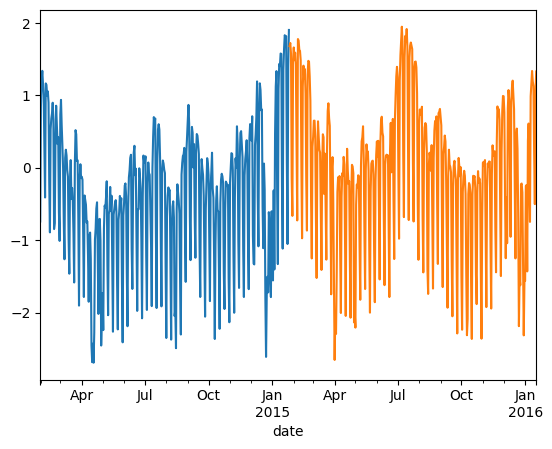

TRAIN: 717 TEST: 357


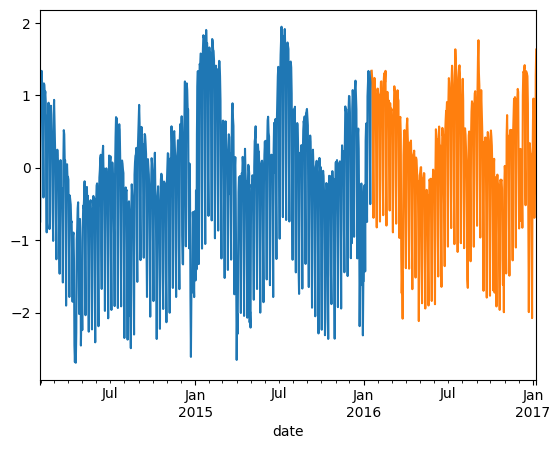

TRAIN: 730 TEST: 357


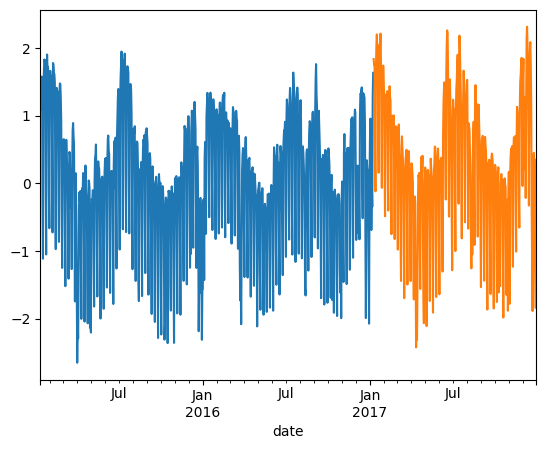

In [28]:
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
for train_index, val_index in splits.split(X_train):
    print("TRAIN:", len(train_index), "TEST:", len(val_index))
    y_train["target_t1"][train_index].plot()
    y_train["target_t1"][val_index].plot()
    plt.show()


The code performs time series cross-validation with a RandomForestRegressor using TimeSeriesSplit with 3 splits and a maximum training size of 2 years (365*2 days). It searches for the best hyperparameters from the given grid, fits the model on training data for each split, and prints the best hyperparameters and corresponding train and validation RMSE scores.






In [29]:
from sklearn.ensemble import RandomForestRegressor

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
rfr = RandomForestRegressor()
# Create a dictionary of hyperparameters to search
rfr_grid = {"n_estimators": [500],
        'max_depth': [3, 5, 10, 20, 30],
        'max_features': [4, 8, 16, 32, 59],
        'random_state': [123]}
rfr_paramGrid = ParameterGrid(rfr_grid)

def TimeSplit_ModBuild(model, paramGrid, splits, X, y):
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error

    #Loop over each time split and for each
    for train_index, val_index in splits.split(X_train):
        _X_train_ = X.iloc[train_index]
        _y_train_ = y.iloc[train_index]
        _X_val_ = X.iloc[val_index]
        _y_val_ = y.iloc[val_index]

        train_scores = []
        val_scores = []
        #models = []

        # Loop through the parameter grid, set the hyperparameters, and save the scores
        for g in paramGrid:
            model.set_params(**g)
            model.fit(_X_train_, _y_train_)
            p_train = model.predict(_X_train_)
            p_val = model.predict(_X_val_)
            score_train = np.mean(mean_squared_error(_y_train_, p_train))
            score_val = np.mean(mean_squared_error(_y_val_, p_val))
            train_scores.append(score_train)
            val_scores.append(score_val)
            #models.append(model)
            best_idx = np.argmin(val_scores)

        print("Best-Fold HyperParams:: ", paramGrid[best_idx])
        print("Best-Fold Train RMSE: ", train_scores[best_idx])
        print("Best-Fold Val RMSE: ",val_scores[best_idx])
        print("\n")

    #Return most recent model
    return train_scores, val_scores, best_idx


CV_rfr_tup = TimeSplit_ModBuild(rfr, rfr_paramGrid, splits, X_train, y_train["target_t1"])

Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 32, 'max_depth': 10}
Best-Fold Train RMSE:  0.030324468201182342
Best-Fold Val RMSE:  0.21215787764817834


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 16, 'max_depth': 20}
Best-Fold Train RMSE:  0.022225084451683037
Best-Fold Val RMSE:  0.18590042166791146


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 16, 'max_depth': 10}
Best-Fold Train RMSE:  0.028482009744979626
Best-Fold Val RMSE:  0.217026072216893




The code selects the best hyperparameters for the RandomForestRegressor model based on the results from the time series cross-validation. It then creates a new RandomForestRegressor instance with the best hyperparameters and fits it to the training data from 2016 to 2017.






In [30]:
best_rfr_idx = CV_rfr_tup[2]
best_rfr_grid = rfr_paramGrid[best_rfr_idx]
best_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train.loc["2016":"2017"], y_train.loc["2016":"2017", "target_t1"])


### Feature Importance

The code calculates feature importances from the trained RandomForestRegressor model and then plots a bar chart to visualize the top 10 most important features. The features are labeled on the x-axis, and the height of each bar represents the importance of the corresponding feature.






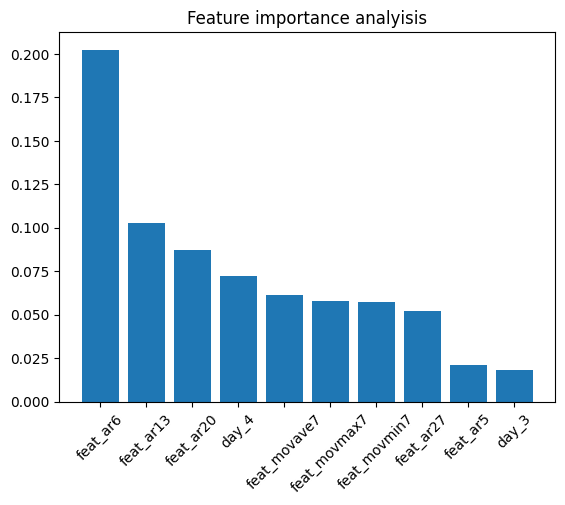

In [31]:
# Get feature importances from our random forest model
importances = best_rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:10]
x = range(len(sorted_index_top))

# Create tick labels
labels = np.array(features)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature importance analyisis")
# Rotate tick labels to vertical
plt.xticks(rotation=45)
plt.show()

## Model Assessment:

### Performance Metrics: MAPE (Mean Absolute Percent Error)

The code calculates the predictions for the target variable on the training and test datasets using the trained RandomForestRegressor model (best_rfr). It then calculates the residuals (differences between actual and predicted values) for both datasets.






In [32]:
p_train = best_rfr.predict(X_train)
train_resid_1step = y_train["target_t1"]- p_train

p_test = best_rfr.predict(X_test)
test_resid_1step = y_test["target_t1"]- p_test

The code transforms the predictions and residuals back to their original scale (before normalization) by multiplying with the standard deviation and adding the mean. It then calculates the Mean Absolute Percentage Error (MAPE) for the 1-period ahead forecasting on the test dataset.






In [33]:
test_df = y_test[["target_t1"]]*std+mean
test_df["pred_t1"] = p_test*std+mean
test_df["resid_t1"] = test_df["target_t1"].add(-test_df["pred_t1"])
test_df["abs_resid_t1"] = abs(test_df["resid_t1"])
test_df["ape_t1"] = test_df["resid_t1"].div(test_df["target_t1"])

test_MAPE = test_df["ape_t1"].mean()*100
print("1-period ahead forecasting MAPE: ", test_MAPE)

1-period ahead forecasting MAPE:  0.08747070456988605


The code plots the actual target values and the 1-period ahead predicted values from the test dataset, helping visualize the forecasting performance of the model.






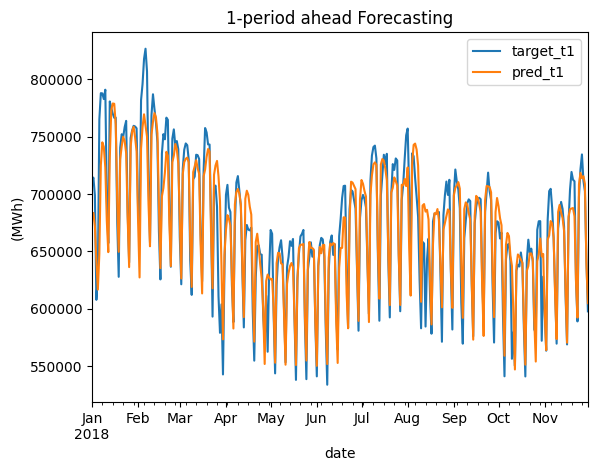

In [34]:
test_df[["target_t1", "pred_t1"]].plot()

plt.title("1-period ahead Forecasting")
plt.ylabel("(MWh)")
plt.legend()
plt.show()

MAPE is slightly over 10%, considering that electricity demand is highly dependend on weather, and February was exceptionally cold, it is an astonishing result. However, can it be improved? Keep reading :)

The code creates a scatter plot showing the 1-period ahead actual target values (y-axis) and the corresponding forecasting values (x-axis) for both the training and test datasets. This visualization helps compare the model's predictions to the actual data points.






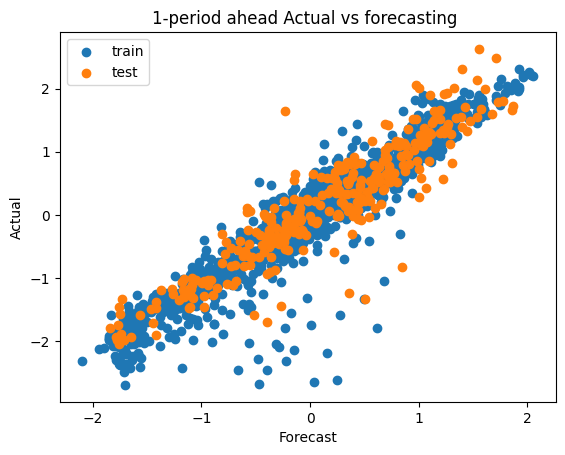

In [35]:
plt.scatter(y=y_train["target_t1"],x=p_train, label="train")
plt.scatter(y=y_test["target_t1"],x=p_test, label="test")
plt.title("1-period ahead Actual vs forecasting ")
plt.ylabel("Actual")
plt.xlabel("Forecast")
plt.legend()
plt.show()

### Residual Analysis

The code generates a histogram to visualize the distribution of 1-step ahead test residuals, which are the differences between the actual target values and the corresponding model predictions. The histogram helps understand the errors made by the model in its predictions.






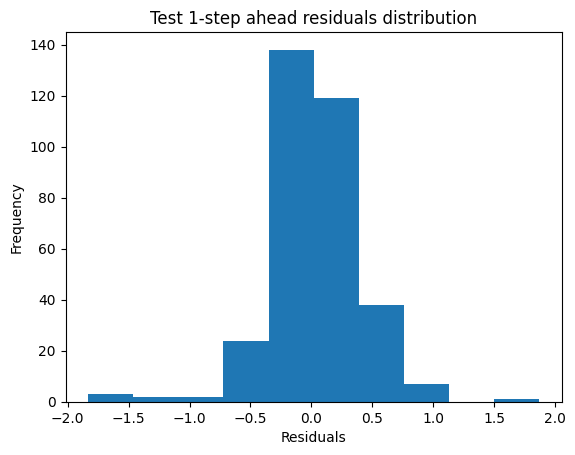

In [36]:
test_resid_1step.plot.hist(bins=10, title="Test 1-step ahead residuals distribution")
plt.xlabel("Residuals")
plt.show()

The code plots the time series of 1-step ahead test residuals, which are the differences between the actual target values and the corresponding model predictions. This helps visualize the pattern of errors made by the model over time.






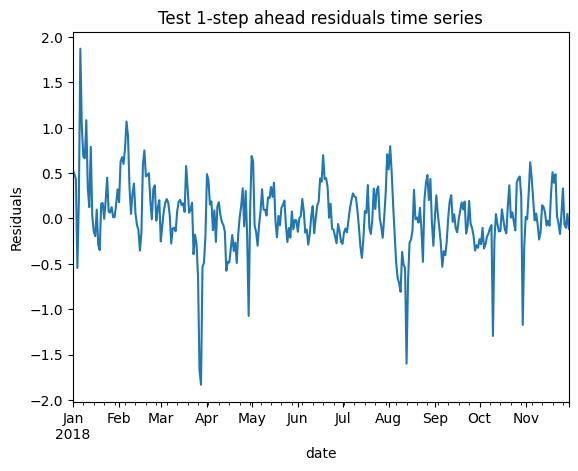

In [37]:
test_resid_1step.plot(title="Test 1-step ahead residuals time series")
plt.ylabel("Residuals")
plt.show()

The code creates a scatter plot showing the relationship between the actual target values and the corresponding 1-step ahead test residuals. This plot helps understand how well the model's predictions match the actual values.






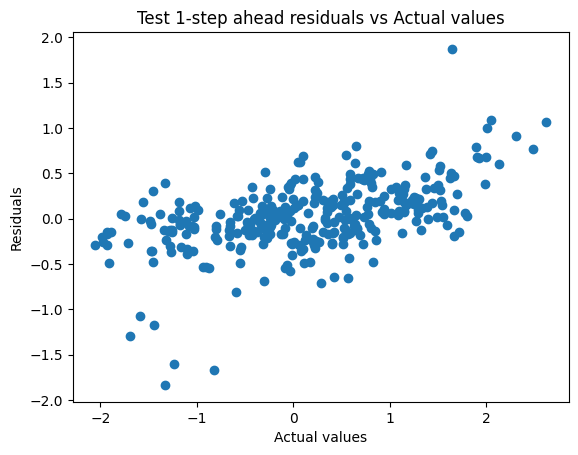

In [38]:
plt.scatter(x=y_test["target_t1"].values, y=test_resid_1step.values)
plt.title("Test 1-step ahead residuals vs Actual values")
plt.ylabel("Residuals")
plt.xlabel("Actual values")
plt.show()

## Forecasting

### Muti-period ahead model building

The code trains a RandomForestRegressor with the best hyperparameters on the training data for the years 2016 and 2017. It uses the previously determined optimal hyperparameters to build the model.






In [39]:
multi_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train.loc["2016":"2017"], y_train.loc["2016":"2017"])

The code uses the trained RandomForestRegressor model to make predictions on the training and test data. It then calculates the 1-step ahead residuals by subtracting the predicted values from the actual target values for both the training and test sets.






In [40]:
p_train = multi_rfr.predict(X_train)
train_resid_1step = y_train- p_train

p_test = multi_rfr.predict(X_test)
test_resid_1step = y_test- p_test

### Performance Metrics: MAPE (Mean Absolute Percent Error)

The code calculates and compares the Mean Absolute Percentage Error (MAPE) for 1, 7, 14, and 30-period ahead predictions made by the RandomForestRegressor model. It calculates the MAPE for each prediction horizon and stores the results in the test_MAPE list.






In [41]:
periods = [1, 7, 14, 30]

ytest_df = y_test*std+mean
ptest_df = pd.DataFrame(data=p_test*std+mean, index=test_df.index, columns=["pred_t" + str(i) for i in range(1, 31)])
test_df = pd.concat([ytest_df, ptest_df], axis=1)

test_MAPE = []

for t in periods:
    test_df["resid_t" + str(t)] = test_df["target_t" + str(t)].add(-test_df["pred_t" + str(t)])
    test_df["abs_resid_t" + str(t)] = abs(test_df["resid_t" + str(t)])
    test_df["ape_t" + str(t)] = test_df["abs_resid_t" + str(t)].div(test_df["target_t" + str(t)])
    test_MAPE.append(round(test_df["ape_t" + str(t)].mean(), 4)*100)

print("MAPE test: ", test_MAPE)

MAPE test:  [2.67, 3.6999999999999997, 3.7900000000000005, 4.2299999999999995]


The code creates a DataFrame "mape_df" with Mean Absolute Percentage Error (MAPE) values for different forecasting periods and then plots a bar chart to visualize the MAPE values for each forecasting period.






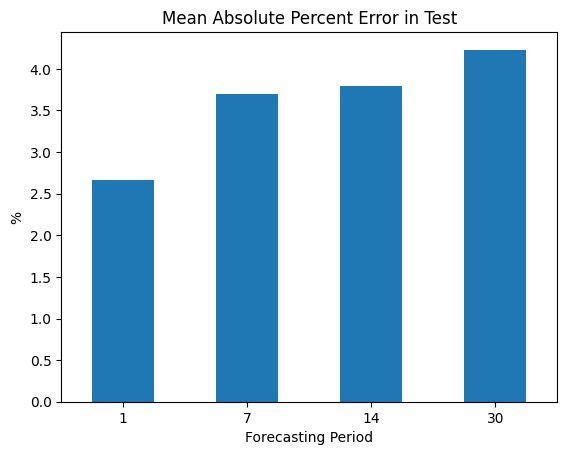

In [42]:
mape_df = pd.DataFrame(index=periods, data={"test_MAPE": test_MAPE})
mape_df.plot(kind="bar", legend=False)
plt.title("Mean Absolute Percent Error in Test")
plt.xlabel("Forecasting Period")
plt.ylabel("%")
plt.xticks(rotation=0)
plt.show()

### Actual vs Forecasted
The code loops through different forecasting periods, creates scatter plots of forecasted values ("pred_t") against actual values ("target_t") for each period, and visualizes the relationship between forecasted and actual values.






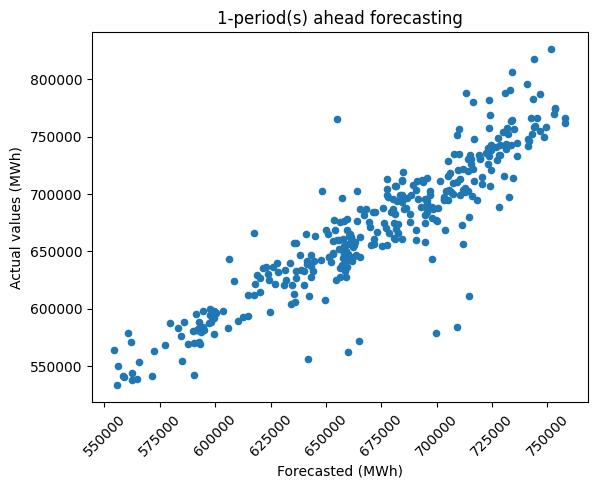

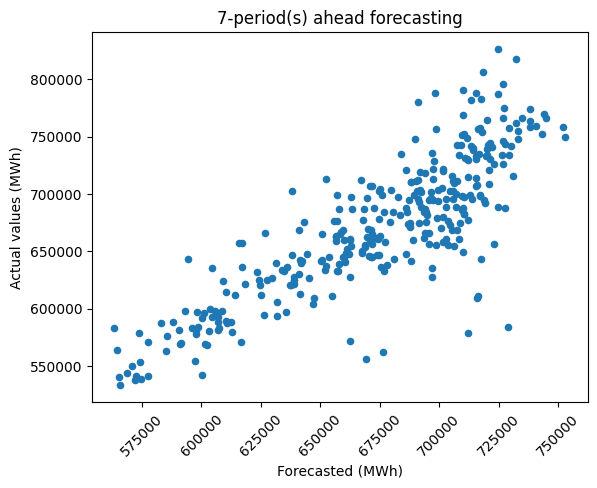

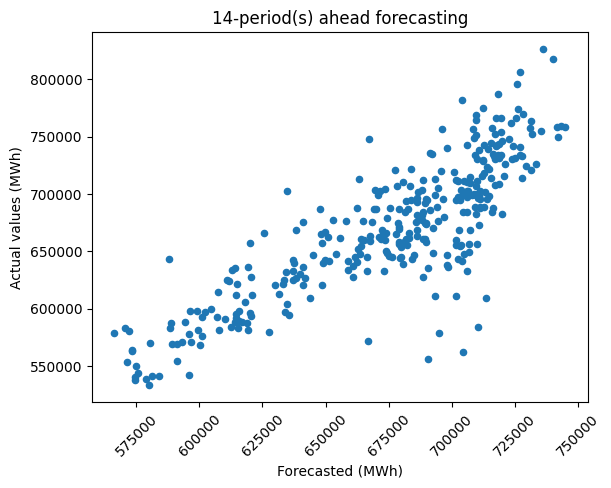

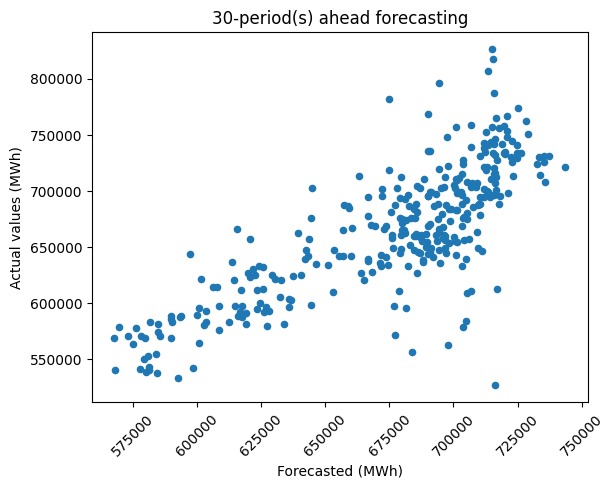

In [43]:
#f, ax = plt.subplots(nrows=3,ncols=2)
for t in periods:
    test_df[["target_t" + str(t), "pred_t" + str(t)]].plot(x="pred_t" + str(t), y="target_t" + str(t) ,kind="scatter")
    plt.title("{}-period(s) ahead forecasting".format(t))
    plt.xlabel("Forecasted (MWh)")
    plt.ylabel("Actual values (MWh)")
    plt.xticks(rotation=45)
    plt.show()

It can be seen that, as forecasting period is longer, scattering is greater, specially for extreme values

### Forecasting 30-days ahead

In [44]:
test_df.index = test_df.index.date

The code generates a date range starting from the maximum date in the test data up to "tau" periods (days) ahead and calculates the length of the forecast range.






In [45]:
forecast_range = pd.date_range(start=np.max(test_df.index.values), periods=tau, freq="D")
len(forecast_range)

30

The code iteratively constructs a forecast for each period in the "tau" range by reversing the predictions (p_test) and converting them to the original scale using mean and standard deviation. However, it only stores the forecast for the last period, effectively overwriting the previous forecasts in each iteration.



In [46]:
forecast = []
for t in range(0, tau):
    #print(-(t+1), (t))
    forecast = p_test[-(t+1):,(t)]*std+mean

The code plots the actual target values for the test period, along with the predicted values (in red) for the test set and the forecasting range. The forecasting line represents the forecasted electricity consumption in the Spanish market for 2018.






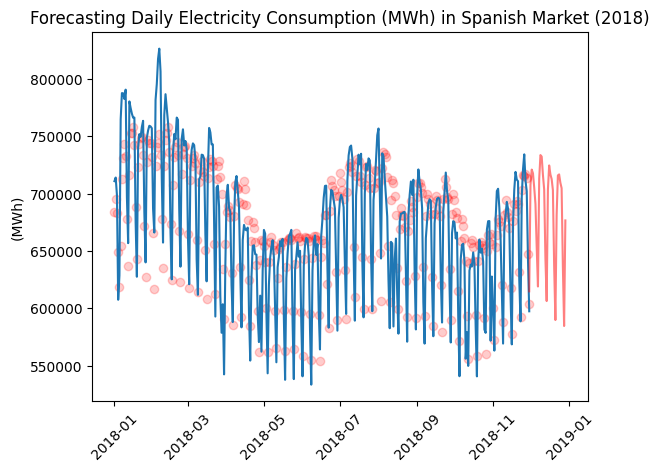

In [47]:
test_df["target_t1"].plot()
plt.scatter(x=test_df.index, y=test_df["pred_t1"], c="r", alpha=0.2, label="test preds")
plt.plot(forecast_range, forecast, c="r", alpha=0.5, label="forecasting")
plt.ylabel("(MWh)")
plt.xticks(rotation=45)
plt.title("Forecasting Daily Electricity Consumption (MWh) in Spanish Market (2018)")
plt.show()

I hope that this has been an interesting LAB, and that you have enjoyed the exercise. Let's point out futher topics:
* Use a MLP (maybe a Keras NN with several neurons in the output layer and a custom perfomance metric)
* Use advanced feature engineering and independent variables
* Implement calendar